# Sentiment Analysis LSTM

This script performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is in turn used to predict the sentiments behind tweets fetched in real time using tweepy and classify them as positive negative or neutral.

The model is then integrated with streamlit and deployed as a web-app.


In [ ]:
!pip install tweepy

'''
To fetch tweets from twitter, we need to install the tweepy library. 
We will be using this package to pull tweets on which our model will make predictions.
'''

'\nTo fetch tweets from twitter, we need to install the tweepy library. \nWe will be using this package to pull tweets on which our model will make predictions.\n'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis
Cleaning and prepping dataset



The category column has 3 values:

->0 Indicating it is a Neutral Sentiment

->1 Indicating a Postive Sentiment

->-1 Indicating a Negative Sentiment

In [ ]:
df1 = pd.read_csv('drive/MyDrive/SMA/Twitter_Data.csv')
# Output first five rows
df1.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
# Load Tweet dataset
df2 = pd.read_csv('drive/MyDrive/SMA/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
# Output first five rows

df2.head()

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0
1,What Happened To Apple Inc? http://t.co/FJEX...,0.0
2,Thank u @apple I can now compile all of the pi...,1.0
3,The oddly uplifting story of the Apple co-foun...,0.0
4,@apple can i exchange my iphone for a differen...,0.0


In [ ]:
# Load Tweet dataset
df3 = pd.read_csv('drive/MyDrive/SMA/finalSentimentdata2.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df3 = df3.drop(['Unnamed: 0'], axis=1)
# Output first five rows
df3.head()

,category,clean_text
0,-1.0,agree the poor in india are treated badly thei...
1,1.0,if only i could have spent the with this cutie...
2,1.0,will nature conservation remain a priority in ...
3,-1.0,coronavirus disappearing in italy show this to...
4,-1.0,uk records lowest daily virus death toll since...


In [ ]:
# Load Tweet dataset
df4 = pd.read_csv('drive/MyDrive/SMA/Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]
# Output first five rows
df4.head()

,category,clean_text
0,0.0,@VirginAmerica What @dhepburn said.
1,1.0,@VirginAmerica plus you've added commercials t...
2,0.0,@VirginAmerica I didn't today... Must mean I n...
3,-1.0,@VirginAmerica it's really aggressive to blast...
4,-1.0,@VirginAmerica and it's a really big bad thing...


In [ ]:
df=pd.concat([df1,df2,df3,df4],ignore_index=True)

In [ ]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df.dropna(axis=0,inplace=True)

df.shape

(182329, 2)

In [ ]:
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


## Exploratory Data Analysis
Data Visualisation

In [ ]:
# The distribution of sentiments

df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

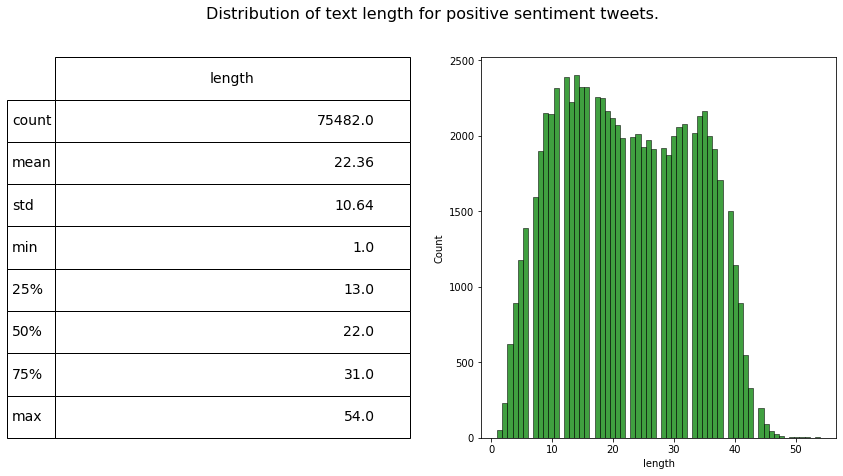

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

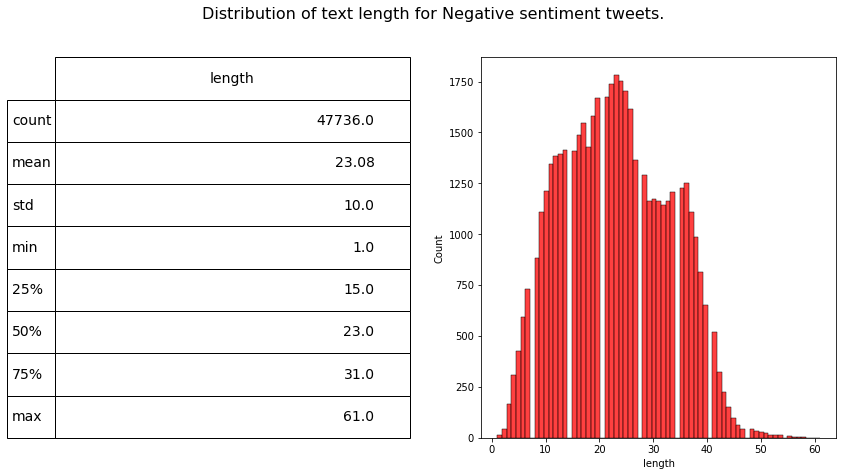

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [ ]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [ ]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
182335  @AmericanAir thank you we got on a different f...  Positive
182336  @AmericanAir leaving over 20 minutes Late Flig...  Negative
182337  @AmericanAir Please bring American Airlines to...   Neutral
182338  @AmericanAir you have my money, you change my ...  Negative
182339  @AmericanAir we have 8 ppl so we need 2 know h...   Neutral

[182329 rows x 2 columns]>

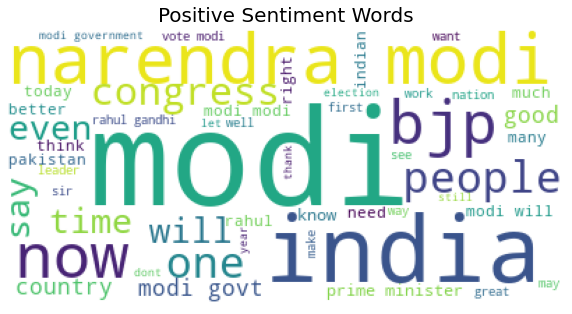

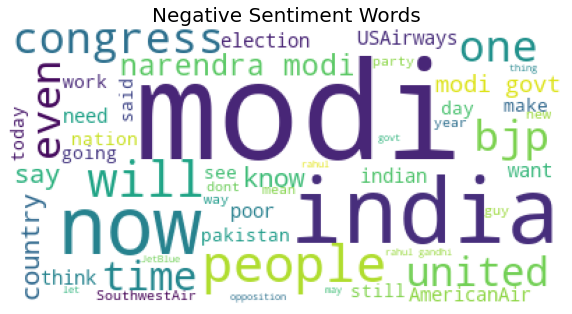

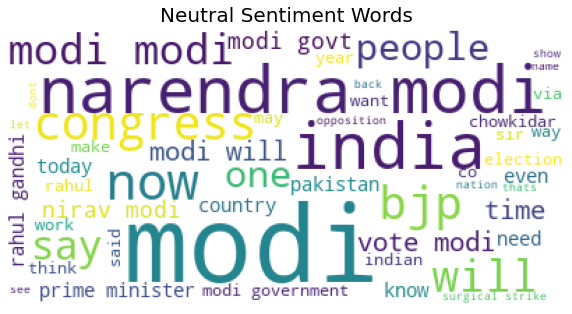

In [ ]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
print()   
# Negative tweet words
wordcount_gen(df, 'Negative')
print()
# Neutral tweet words
wordcount_gen(df, 'Neutral')

## Data Preprocessing

In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


Train and test split

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Bag of words (BOW) feature extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['0', '000', '1', '10', '100', '1000', '10000', '10th', '11', '111', '1145', '11th', '12', '1200', '12000', '125', '12k', '130', '140', '14000', '15', '150', '1500', '1500000', '1520', '157200000', '15l', '15lac', '15lakh', '18', '180', '19', '1947', '1958', '1962', '1969', '1971', '1980', '1984', '1998', '1st', '2', '20', '200', '2000', '2002', '2004', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2022', '2024', '2029', '21st', '23', '23rd', '24', '247', '24x7', '25', '250', '2611', '26th', '272', '27th', '280319', '282', '28th', '2cr', '2day', '2nd', '3', '30', '300', '3000', '30000', '300km', '31st', '350', '35a', '370', '3rd', '4', '40', '400', '4000', '45', '456', '4th', '5', '50', '500', '5000', '50000', '5th', '5year', '5yr', '6', '60', '600', '6000', '6th', '7', '72000', '7200000', '72k', '7th', '8', '80', '800', '8020', '9', '90', '9000', 'aa', 'aadhaar', 'aadhar', 'aadmi', 'aag', 'aaj', 'aalo', 'aam', 'aan', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



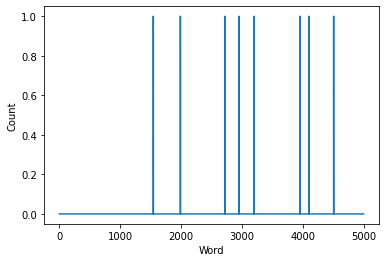

In [ ]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

## Tokenizing & Padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  41    1  349   73 1911 1180   44 2465    2 1259  219    2  236   32
  165  102   53   55 1184  236   50    3    6  533    3   50 3833    3
 3077    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


##Saving tokenized data

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Train & Test Split

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (109397, 50) (109397, 3)
Validation Set -> (36466, 50) (36466, 3)
Test Set -> (36466, 50) (36466, 3)


In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



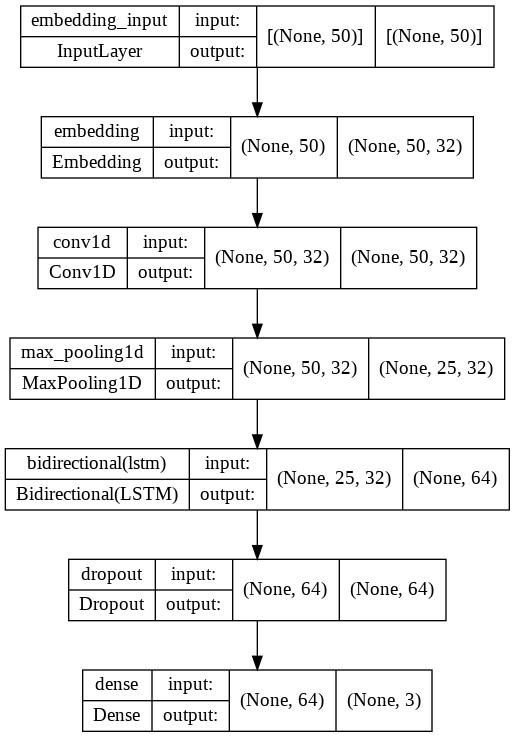

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

Model Accuracy & Loss

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8945
Precision : 0.8994
Recall    : 0.8887
F1 Score  : 0.8940


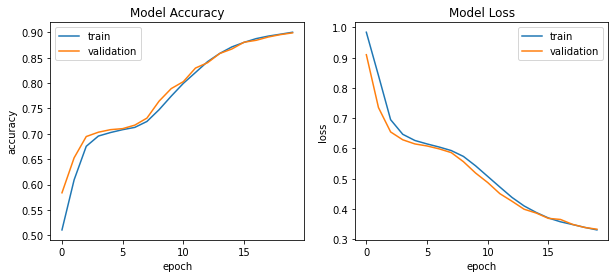

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

Model Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model save and load for the prediction

In [ ]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [ ]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

The predicted sentiment is Negative


In [ ]:
predict_class(['The food was meh'])

In [ ]:
predict_class(['He is a best minister india ever had seen'])

---------------------------------------------------------------------------------------------------------

## Fetching data from twitter
Authorization

In [ ]:
#Getting authorization
consumer_key= 'WVjgb9NQOo2l3Aoma0XCf2uTG'
consumer_secret= 'rrbv0hFP5H7YpKMudOI9nayqC3MURX0HLoGrIs3v24mc8EruNa'
access_token= '1513765254752182272-pvTZb0wF4ZuWUDSeQmQfFN4cxyQucp'
access_token_secret= 'Lq9z34WWzKPBmEQIUAXrsHGbki0l8qt5aMVEny0LjEFnP'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Search Twitter for Tweets

In [ ]:
# Define the search term and the date_since date as variables
search_words = "#IPL"
date_since = "2022-04-24"

In [ ]:
# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(10)

# Iterate and print tweets
for tweet in tweets:
    print(tweet.text)
    predict_class([tweet.text]) #predicting sentiment
    print("")

Searching for a keyword

In [ ]:
for tweet in api.search(q="elonmusk", lang="en", rpp=10):
    print(f"{tweet.user.name}:{tweet.text}")
    predict_class([tweet.text]) #predicting sentiment
    print("")

Mehdi Sadeghi8484:RT @DOGELONMARSIRA2: @beeple @elonmusk I am dogelon, dogelonmars
#Elon
#dogelon
#DOGELONMARS
@mfoundation
#DogelonWarriors
#Binance https:/…
The predicted sentiment is Neutral

TakShak :RT @urs_truly_urs: Boys will be boys 

@elonmusk

https://t.co/Z9L0iKHjkm https://t.co/ICtrK7Nlil
The predicted sentiment is Neutral

Your Daddy:@elonmusk Now we have all these damn insurrectionists shit.
The predicted sentiment is Negative

naseem mujalli:@elonmusk I’m the perfect candidate for neural link human trials can you get me in 🙏🙏🙏🙏. @elonmusk
The predicted sentiment is Positive

DutchFreedomWriter:@the_stinging @elonmusk I love it
The predicted sentiment is Positive

minsau:RT @enriquesouza_: These are the Last minutes of censorship; I can feel the fresh air coming! 

@coinkit_ give 0.1 1 $sol @elonmusk
The predicted sentiment is Positive

Fik 🦋:RT @ApiInu: API Inu was launched the same day as #ElonMuskBuyTwitter #ElonMusk #ElonMuskTwitter #ElonMuskBuysTwitter , so much @el

 Searching for a username

In [ ]:
posts = api.user_timeline(screen_name="elonmusk", count = 10, lang ="en", tweet_mode="extended")

l=[] 
i=1

for tweet in posts[:10]:
    l.append(tweet.full_text) 
    i=i+1
for j in range (0,9):
    print(l[j])
    predict_class([l[j]])  #predicting sentiment
    print("\n")

NameError: ignored